# ================================================
# 모든 상장회사
# 데이터는 QuantDataR.xlsx 사용

In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import numpy as np
import pandas as pd
import random
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Colab 사용할 경우 구글드라이버 폴더에 접근하게 함
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# 시장수익률과 무위험자산 수익률을 읽음
sdata = pd.read_csv("/gdrive//MyDrive/QuantFinance/data.csv", index_col=0)
# sdata = pd.read_csv("data.csv",index_col=0)   # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시

sdata.index = pd.to_datetime(sdata.index)
#sdata = sdata.dropna(axis=0).drop('Dates', axis=1).reset_index(drop =True)
T = sdata.shape[0]
MR = sdata['RKOSPI']
RF = sdata['RF_M']

MR = MR[1:168]
RF = RF[1:168]

print("데이터형식 확인")
print(RF)

데이터형식 확인
Dates
2006-09-29    0.373
2006-10-31    0.373
2006-11-30    0.373
2006-12-29    0.374
2007-01-31    0.386
              ...  
2020-03-31    0.083
2020-04-30    0.062
2020-05-29    0.058
2020-06-30    0.040
2020-07-31    0.040
Name: RF_M, Length: 167, dtype: float64


In [5]:
# 개별자산 데이터, 전체 데이터 읽음  다소 시간이 많이 걸림 (2분 정도)
# data= 'QuantDataR.xlsx'
# df = pd.read_excel(data, None, index_col=0 )  # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시
df = pd.read_excel("/gdrive//MyDrive/QuantFinance/QuantDataR.xlsx", None, index_col=0 )
df_names = list(df.keys())

print("==========================================================================")
print("Spreadsheet 확인")
print(df_names)

Spreadsheet 확인
['D_Market', 'D_RI', 'D_TradingValue', 'D_P', 'M_Market', 'Beta', 'Volatility', 'DY', 'RI', 'TradingValue', 'Cash', 'AccReceivables', 'Inventory', 'CurrentAsset', 'R&D', 'Plants', 'Intangible', 'Total Asset', 'AccPayable', 'CurrentLiability', 'LongTermDebt', 'TotalLiability', 'CommonEquity', 'TotalShareEqu', 'Sales', 'CoGS', 'DepArm', 'OperatingIncome', 'EBIT', 'Interest', 'NetIncome', 'DividendPerShare', 'EPS', 'CommonShares', 'Investment', 'Employee', 'WorkingCap', 'MarketValue']


In [6]:
# 개별주식의 총수익률 (RI) 데이터 읽음
RID = df['RI']
RID = RID.iloc[0:168,:]
print("--------------------------------------------------------------------------")
print("데이터형식 확인")
print(RID)

# Dates
date = RID.index
print("--------------------------------------------------------------------------")
print("Dates")
print(date)

#firm names using 'D_Price'  이름 이외에는 다른 군더기가 없음 ㅎ
D_Price = df['D_P']
firm_names =  D_Price.columns
print("--------------------------------------------------------------------------")
print("FIrm Names")
print(firm_names)

--------------------------------------------------------------------------
데이터형식 확인
            A SELF-ADMINISTERED REIT.TST. - TOT RETURN IND  \
Name                                                         
2006-08-31                                             NaN   
2006-09-29                                             NaN   
2006-10-31                                             NaN   
2006-11-30                                             NaN   
2006-12-29                                             NaN   
...                                                    ...   
2020-03-31                                          142.09   
2020-04-30                                          148.71   
2020-05-29                                          171.99   
2020-06-30                                          167.76   
2020-07-31                                          170.41   

            ABLE C&C - TOT RETURN IND  AEKYUNG IND - TOT RETURN IND  \
Name                                  

In [7]:
############################################################################################
# Calculation of log-returns

R = []
# print("Null stocks: ", end ='')    # end=''  다음 출력이 같은 줄에 프린트하기
for i in range(0,RID.shape[1]):

    if RID.shape[0] - RID.iloc[:, i ].isnull().sum() < 2:   # 전체 T개의 관찰치중 NA개수를 뺀 나머지가 2 보다 작으면 계산하지 않음

        # print (i, ", ", end='')
        R_temp = pd.Series([np.nan]*(RID.shape[0]-1))    #전체를 NA로 대체
        R.append(R_temp)
        continue            # 반복문 내에서만 사용되며, 반복이 진행되는 도중 continue문을 만나면 반복문의 끝으로 이동하여 다음 반복문(i+1)으로 넘어감.

    log0 = (np.log(RID.iloc[1:, i ])).reset_index(drop =True)     # drop=True옵션을 주면 기존 인덱스를 버리고 재배열
    log1 = (np.log(RID.iloc[0:-1, i ])).reset_index(drop =True)

    R_temp =  (log0-log1)*100
    R.append(R_temp)

# print(sep ='')   # print문의 출력문들 사이에 ''안의 내용 삽입

R = pd.concat(R,axis= 1)   # R이라는 matrix는 각 개별주식의 수익률 벡터를 순차적으로 오른편으로 덧붙여 작성. axis=0 이면 아래쪽으로 붙임
R.index = date[1:]         # 첫달 제외
R.columns = firm_names     # 회사이름

print("=========================================================================")
print("Return Data")
print(R)

Return Data
            A SELF-ADMINISTERED REIT.TST.   ABLE C&C  AEKYUNG IND  AIR BUSAN  \
Name                                                                           
2006-09-29                            NaN   4.372000          NaN        NaN   
2006-10-31                            NaN  24.040686          NaN        NaN   
2006-11-30                            NaN -13.268377          NaN        NaN   
2006-12-29                            NaN  -9.720986          NaN        NaN   
2007-01-31                            NaN -14.786239          NaN        NaN   
...                                   ...        ...          ...        ...   
2020-03-31                      -9.755336 -23.177143   -10.758720 -31.234498   
2020-04-30                       4.553744  23.177143    20.286260  28.275434   
2020-05-29                      14.543823  -9.827651   -13.454202  -3.198141   
2020-06-30                      -2.490195   0.864266    -6.181051   0.513237   
2020-07-31                  

In [8]:
# Choose one date for testing
# rndate = random.randint(62,len(date)-59)   #Randomly Selecting a month from 2011 excluding 2016 and onword
rndate = 72

print("--------------------------------------------------------------------------")
print("Selected Date")
print(R.index[rndate]) #Print the selected month


--------------------------------------------------------------------------
Selected Date
2012-09-28 00:00:00


In [9]:
MR_s = MR[rndate :  rndate+60]   #.reset_index(drop =True)
RF_s = RF[rndate :  rndate+60]   #.reset_index(drop =True)

R_test  =  R.iloc[rndate :  rndate+60,:]
Sdate = R_test.index

# Remove firms whose returns are not available
R_test = R_test.dropna(axis= 1)

print("-------------------------------------------------------------------------")
print("Selected Returns")
print(R_test)


-------------------------------------------------------------------------
Selected Returns
            A SELF-ADMINISTERED REIT.TST.   ABLE C&C  AJU CAPITAL  \
Name                                                                
2012-09-28                      -1.477926  13.132923     0.833236   
2012-10-31                       1.130564   0.662741    -9.544442   
2012-11-30                      -5.671765  -6.366568    -5.874694   
2012-12-31                      -0.710735   2.421138     3.963678   
2013-01-31                      -8.124409  -3.744091    -0.617667   
2013-02-28                       1.031334  -4.715786     7.261200   
2013-03-29                      -3.411280  17.076162     9.239592   
2013-04-30                       3.411280 -35.832378     5.286222   
2013-05-31                       8.748345 -27.284043    12.943988   
2013-06-28                       1.531637 -12.187634    -2.143642   
2013-07-31                     -19.884533  -8.497000    -3.695313   
2013-08-30  

In [10]:
R_Excess = pd.DataFrame(np.empty((R_test.shape[0],R_test.shape[1]))*np.nan, columns = R_test.columns, index=Sdate)

for i in range(0,R_test.shape[1]):
    # R_Excess.iloc[:,i] = (R_test.iloc[:,i]) # excess returns of individual stocks
    R_Excess.iloc[:,i] = (R_test.iloc[:,i]-RF_s) # excess returns of individual stocks


In [11]:
X = MR_s-RF_s # excess market return
XX = sm.add_constant(X)

Coefficients = pd.DataFrame(np.empty((2,R_Excess.shape[1]))*np.nan, columns = R_Excess.columns, index=['Alpha', 'Beta'])
for i in range(0,R_Excess.shape[1]):

    # Y = (R_Excess.iloc[:,i]-RF_s).values # excess returns of individual stocks
    Y = (R_Excess.iloc[:,i]).values # excess returns of individual stocks
    Coefficients.iloc[:,i] = np.linalg.inv(XX.T @ XX) @ (XX.T @ Y)

print("-------------------------------------------------------------------------")
print("Estimates of the Market Model")
print(Coefficients)


-------------------------------------------------------------------------
Estimates of the Market Model
       A SELF-ADMINISTERED REIT.TST.  ABLE C&C  AJU CAPITAL  AK HOLDINGS  \
Alpha                       0.528200 -1.555751     0.949693     1.223977   
Beta                       -0.199563  0.553558     0.779384     0.578803   

          ALUKO  AMOREPACIFIC  AMOREPACIFIC GROUP  ANAM ELECTRONICS  \
Alpha  0.496126      1.224609            1.500097          1.699123   
Beta   1.417945      0.793334            1.263884          2.536943   

       APROGEN KIC  APROGEN PHARMACEUTICALS  ...  YOUNGBO CHEMICAL  YOUNGONE  \
Alpha    -1.056883                 0.925943  ...          0.516897 -0.155600   
Beta     -0.574158                -0.316591  ...          1.307936  0.043182   

       YOUNGONE HOLDINGS  YOUNGWIRE  YUANTA SECURITIES KOREA     YUHAN  \
Alpha          -0.427427  -0.959302                -0.684681  0.755898   
Beta            0.439002   1.290964                 2.245760  0.

In [ ]:
print("Alpha")
print("Mean:",Coefficients.loc["Alpha"].mean(), "  SD:",Coefficients.loc["Alpha"].std(),"  skwness:",Coefficients.loc["Alpha"].skew()," kurtosis:",Coefficients.loc["Alpha"].kurtosis())

print("Beta")
print("Mean:",Coefficients.loc["Beta"].mean(), "  SD:",Coefficients.loc["Beta"].std(),"  skwness:",Coefficients.loc["Beta"].skew()," kurtosis:",Coefficients.loc["Beta"].kurtosis())

Alpha
Mean: 0.2169392273003251   SD: 1.375448534231473   skwness: -1.5168601323265996  kurtosis: 7.175418457324362
Beta
Mean: 0.7984642404344202   SD: 0.7263498999591756   skwness: 0.29574613893086216  kurtosis: 2.2175676550253893


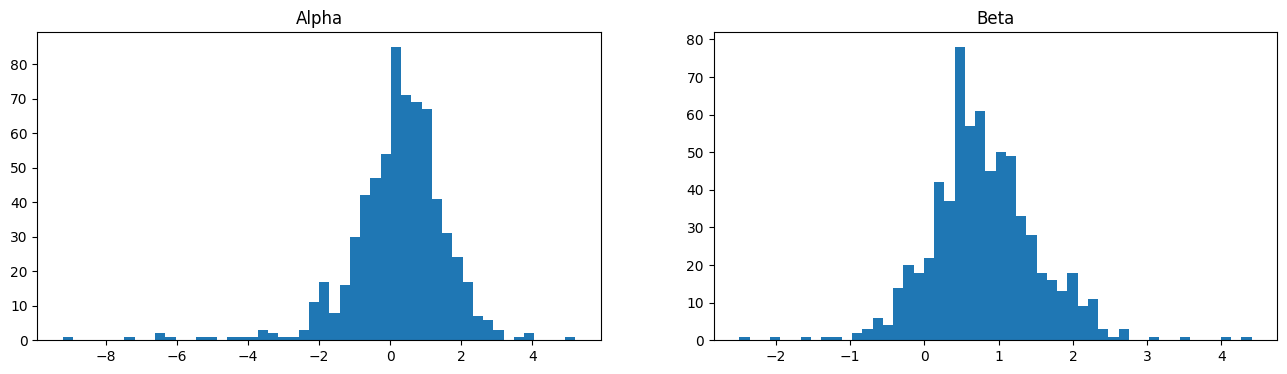

In [12]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.hist(Coefficients.loc["Alpha"] ,bins=50)
plt.title('Alpha')

plt.subplot(122)
plt.hist(Coefficients.loc["Beta"],bins=50)
plt.title('Beta')
plt.show()

In [13]:
CXX = sm.add_constant(Coefficients.loc["Beta"])

Cgamma = pd.DataFrame(np.empty((R_Excess.shape[0],2))*np.nan, index = Sdate)
for t in range(0,Sdate.shape[0]):
    temp = np.linalg.inv(CXX.T @ CXX) @ (CXX.T @ R_Excess.iloc[t,:].T)
    Cgamma.iloc[t,:] = temp.T

Gamma0 = Cgamma.iloc[:,0]
Gamma1 = Cgamma.iloc[:,1]

Cgamma

,0,1
Name,,
2012-09-28,2.659334,3.275747
2012-10-31,3.296167,-8.370299
2012-11-30,-3.500180,1.398655
2012-12-31,-1.709352,3.757841
2013-01-31,4.769025,-3.262351
2013-02-28,1.233749,0.923252
2013-03-29,4.903271,-2.731029
2013-04-30,5.782459,-5.106604
2013-05-31,0.392223,2.089845


In [14]:
print("Gamma0")
print("Mean:", Gamma0.mean(), "  SD:", Gamma0.std(),"  skwness:", Gamma0.skew()," kurtosis:", Gamma0.kurtosis())

print("Gamma1")
print("Mean:", Gamma1.mean(), "  SD:", Gamma1.std(),"  skwness:", Gamma1.skew()," kurtosis:", Gamma1.kurtosis())

Gamma0
Mean: 0.6513112020473615   SD: 2.777031317972868   skwness: -0.19078849307188653  kurtosis: -0.7155389887577601
Gamma1
Mean: -0.346275969463631   SD: 2.9774510043470106   skwness: -0.3178018948191224  kurtosis: -0.2725786822734433


In [15]:
avg_rtn = R_Excess.mean().reset_index(drop =True)

print("correlation : " , np.corrcoef(R_Excess.mean(), Coefficients.loc["Beta"])[0,1])  # scipy.stats.spearmanr(Excess_return.mean(), Coefficients.iloc[1,:]).correlation)

model =  sm.OLS(R_Excess.mean(), sm.add_constant(Coefficients.loc["Beta"]))  # 종속변수는 평균초과수익률, 설명변수는 베타

CAPM = model.fit()

print(CAPM.summary())

correlation :  -0.1875230578450652
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     24.35
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           1.02e-06
Time:                        05:32:28   Log-Likelihood:                -1134.9
No. Observations:                 670   AIC:                             2274.
Df Residuals:                     668   BIC:                             2283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

Text(0, 0.5, 'Excess Return')

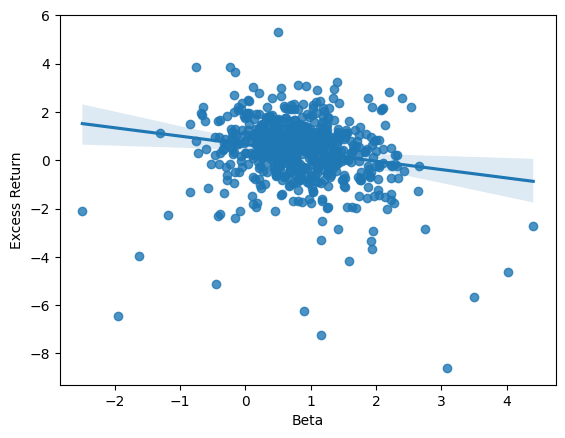

In [16]:
sns.regplot(x= Coefficients.loc["Beta"],
            y=R_Excess.mean(),
            fit_reg=True) # default
plt.xlabel("Beta")
plt.ylabel("Excess Return")

# ===============================================
# ===============================================
# 과제 I

# 체계적 위험의 추정과 CAPM 검증

퀀트데이터에서 10개의 주식을 골라서 60개월의 월별 자료로 베타를 구하라.

- 추정된 베타는 통계적으로 유의미한가?

- 추정된 알파는 영과 같은가?

- 같은 주식에 대하여 24개월이나 84개월을 사용하면 결과가 달라지는가?


퀀트데이터에 있는 베타를 활용하여 CAPM을 테스트하라.

- 임의로 100개의 주식을 선택한 다음 2015년 1월부터 2018년 12월까지 각 월별로 다음 회귀식 추정하여 𝛾_0과 𝛾_1를 구하라.

	 𝑟_𝑖𝑡−𝑟_𝑓=𝛾_0𝑡+𝛾_1𝑡 𝛽_𝑖𝑡+𝜖_𝑖𝑡

- 이 경우 𝛾_0과 𝛾_1에 대한 귀무가설은 어떻게 되는가?

- CAPM이 개별자산의 수익률을 설명하는가?

- 이 분석방법의 문제는 무엇이고, 이를 피할 수 있는 방법은 무엇인가?

